# Prep

In [6]:
import pandas as pd
import datetime as dt
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# pd.options.plotting.backend = "plotly" # Set default charting for pandas to plotly

from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all" # show all output for cell
pd.set_option('display.max_columns', None)

In [2]:
# Importing Alpaca SDK
from keys_config import *

import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame
from pytz import timezone

from alpaca.trading.client import TradingClient
from alpaca.trading.enums import OrderSide, TimeInForce, AssetClass, AssetStatus, AssetExchange, OrderStatus
from alpaca.trading.requests import GetCalendarRequest, GetAssetsRequest, GetOrdersRequest, MarketOrderRequest, LimitOrderRequest, StopLossRequest, TrailingStopOrderRequest, GetPortfolioHistoryRequest
from alpaca.data import StockHistoricalDataClient
from alpaca.data.requests import StockLatestQuoteRequest, StockTradesRequest, StockQuotesRequest, StockBarsRequest, StockSnapshotRequest, StockLatestBarRequest
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.enums import Adjustment, DataFeed, Exchange
from alpaca.broker.client import BrokerClient
import alpaca

trading_client = TradingClient(API_KEY_PAPER, API_SECRET_PAPER)
stock_client = StockHistoricalDataClient(API_KEY_PAPER,API_SECRET_PAPER)

alpaca_old = tradeapi.REST(API_KEY_PAPER, API_SECRET_PAPER, API_BASE_URL_PAPER, 'v2')

In [3]:
import eikon as ek
ek.set_app_key(eikon_clientId)
ek.get_symbology(['MSFT.O', 'GOOG.O', 'IBM.N']) # for check

CUSIP          ISIN    OAPermID     RIC ticker    SEDOL
MSFT.O  594918104  US5949181045  4295907168  MSFT.O   MSFT     <NA>
GOOG.O  02079K107  US02079K1079  5030853586  GOOG.O   GOOG     <NA>
IBM.N   459200101  US4592001014  4295904307   IBM.N    IBM  2005973

# Fear & Greed


Read csv taken from PartTimeLarry

In [4]:
data = pd.read_csv('D:\\Data\\Other_data\\spy-put-call-fear-greed-vix.csv',parse_dates=['Date'])
data.set_index('Date',inplace=True)
data.dtypes
data

Open        High         Low       Close   Adj Close  \
Date                                                                     
2011-01-03  126.709999  127.599998  125.699997  127.050003  104.563118   
2011-01-04  127.330002  127.370003  126.190002  126.980003  104.505478   
2011-01-05  126.580002  127.720001  126.459999  127.639999  105.048676   
2011-01-06  127.690002  127.830002  127.010002  127.389999  104.842949   
2011-01-07  127.559998  127.769997  126.150002  127.139999  104.637177   
...                ...         ...         ...         ...         ...   
2020-09-14  337.489990  340.380005  334.220001  338.459991  337.110535   
2020-09-15  341.119995  342.019989  338.470001  340.170013  338.813751   
2020-09-16  341.510010  343.059998  338.519989  338.820007  337.469116   
2020-09-17  333.559998  337.700012  332.989990  335.839996  334.501007   
2020-09-18  335.369995  335.489990  327.970001  330.649994  330.649994   

               Volume  Put Call  Fear Greed        VIX  
Date                                                    
2011-01-03  138725200      0.40          68  17.610001  
2011-01-04  137409700      0.43          68  17.379999  
2011-01-05  133975300      0.48          67  17.020000  
2011-01-06  122519000      0.46          64  17.400000  
2011-01-07  156034600      0.50          63  17.139999  
...               ...       ...         ...        ...  
2020-09-14   65605700      0.49          59  25.850000  
2020-09-15   52920900      0.46          59  25.590000  
2020-09-16   82096000      0.51          56  26.040001  
2020-09-17   91523300      0.58          53  26.459999  
2020-09-18  105790800      0.63          52  25.830000  

[2445 rows x 9 columns]

In [12]:
fig1 = px.bar(data['Fear Greed'].value_counts(),title="Values Distribution of Fear-Greed Indicator")
fig1.update_layout(showlegend=False,title_x=0.5)

In [13]:
fig2 = px.histogram(data, x="Volume", nbins=20)
fig2.update_layout(showlegend=False,title_x=0.5)

In [7]:
small_data=data.loc["2019"]
fig = make_subplots(specs=[[{'secondary_y': True}]])
fig.add_trace(go.Scatter(x=small_data.index, y= small_data['Adj Close']), secondary_y=False)  
fig.add_trace(go.Scatter(x=small_data.index, y= small_data['Fear Greed']), secondary_y=True)  

# Alpaca timeseries

In [16]:
symbols = ["SPY", "TSLA", "AAPL"]
timeframe = "1Day"
start = "2022-06-01"
end = "2022-06-30"
# Retrieve daily bars for SPY, TSLA, and AAPL in a DataFrame
bars = alpaca_old.get_bars(symbols, timeframe, start, end).df
spy_bars = bars.loc[bars["symbol"] == "SPY"]
tsla_bars = bars.loc[bars["symbol"] == "TSLA"]
aapl_bars = bars.loc[bars["symbol"] == "AAPL"]
spy_bars.head(2)

open    high     low   close    volume  \
timestamp                                                             
2022-06-01 04:00:00+00:00  415.20  416.24  406.93  409.59  85820291   
2022-06-02 04:00:00+00:00  409.58  417.44  407.04  417.39  78866434   

                           trade_count        vwap symbol  
timestamp                                                  
2022-06-01 04:00:00+00:00       691614  410.785032    SPY  
2022-06-02 04:00:00+00:00       610631  413.382244    SPY

In [17]:
corp_ig = ['VCSH', # US, market-weighted, IG, fixed-rate, 1-5Y maturity corporate bonds
           'VCIT'] # US, market-weighted, IG, fixed-rate, 5-10Y maturity corporate bonds
bars_request_params = StockBarsRequest(
    symbol_or_symbols=corp_ig, 
    start = (pd.Timestamp.now(tz="US/Eastern") - pd.Timedelta(200, "days")).floor(freq='H'), # T - for minutes, H - for hours
    end = pd.Timestamp.now(), # do I need to convert to ET? (tz="US/Eastern") or UTC? pd.Timestamp.utcnow()
    # limit = 100, # upper limit of number of data points
    timeframe=TimeFrame.Day, # 'Day', 'Hour', 'Minute', 'Month', 'Week'
    adjustment= Adjustment.ALL, # RAW, SPLIT, DIVIDEND, ALL
    feed = DataFeed.SIP
    )
hist_bars = stock_client.get_stock_bars(bars_request_params).df # drop level is needed as 1st it appears with multiindex with symbol


In [19]:
short_mat_bars = hist_bars.loc["VCSH"]
long_mat_bars = hist_bars.loc["VCIT"]
long_mat_bars.head()

open   high    low  close     volume  trade_count  \
timestamp                                                                       
2022-04-01 04:00:00+00:00  84.10  84.64  84.05  84.46  3866383.0      15051.0   
2022-04-04 04:00:00+00:00  84.55  84.68  84.47  84.68  8090446.0      32299.0   
2022-04-05 04:00:00+00:00  84.42  84.46  83.60  83.62  4289126.0      15146.0   
2022-04-06 04:00:00+00:00  83.08  83.60  82.92  83.30  7473368.0      28735.0   
2022-04-07 04:00:00+00:00  83.27  83.39  83.02  83.07  5976131.0      17643.0   

                            vwap  
timestamp                         
2022-04-01 04:00:00+00:00  84.41  
2022-04-04 04:00:00+00:00  84.55  
2022-04-05 04:00:00+00:00  83.78  
2022-04-06 04:00:00+00:00  83.19  
2022-04-07 04:00:00+00:00  83.18

In [20]:
hist_bars_no_index = hist_bars.reset_index()
hist_bars_no_index

symbol                 timestamp   open     high    low  close  \
0     VCIT 2022-04-01 04:00:00+00:00  84.10  84.6400  84.05  84.46   
1     VCIT 2022-04-04 04:00:00+00:00  84.55  84.6800  84.47  84.68   
2     VCIT 2022-04-05 04:00:00+00:00  84.42  84.4600  83.60  83.62   
3     VCIT 2022-04-06 04:00:00+00:00  83.08  83.6000  82.92  83.30   
4     VCIT 2022-04-07 04:00:00+00:00  83.27  83.3900  83.02  83.07   
..     ...                       ...    ...      ...    ...    ...   
267   VCSH 2022-10-10 04:00:00+00:00  74.32  74.3200  73.99  74.08   
268   VCSH 2022-10-11 04:00:00+00:00  74.11  74.2300  73.96  73.98   
269   VCSH 2022-10-12 04:00:00+00:00  73.96  74.0162  73.85  73.90   
270   VCSH 2022-10-13 04:00:00+00:00  73.29  73.9199  73.26  73.88   
271   VCSH 2022-10-14 04:00:00+00:00  73.98  74.0900  73.59  73.61   

         volume  trade_count       vwap  
0     3866383.0      15051.0  84.410000  
1     8090446.0      32299.0  84.550000  
2     4289126.0      15146.0  83.780000  
3     7473368.0      28735.0  83.190000  
4     5976131.0      17643.0  83.180000  
..          ...          ...        ...  
267   1936186.0       7471.0  74.087993  
268  16249738.0      12577.0  74.145624  
269  14271384.0      18284.0  73.918350  
270   8919919.0      17575.0  73.713344  
271   6396448.0      14418.0  73.719941  

[272 rows x 9 columns]

In [21]:
fig = px.line(hist_bars_no_index, x="timestamp", y="close", facet_col_spacing=0.05, facet_col="symbol")
# facet_row_spacing=0.03, facet_col_spacing=0.03, facet_col_wrap=4
# fig.update_layout(autosize=False,width=1400,height=2000,)
# fig.update_xaxes(matches=None,showticklabels=True)
fig.update_yaxes(matches=None,showticklabels=True)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1])) # adjusting headers
fig.show()

# Alpaca trades analysis

In [23]:
limit = 10000
spy_trades = alpaca_old.get_trades('SPY', limit=limit).df
exchange_histogram = px.histogram(spy_trades, x="exchange")
exchange_histogram.update_layout(
    title="Frequency of exchanges in the first 10,000 trades of SPY on recent trading day",
    yaxis_title="Number of trades",
    xaxis_title="Exchange")

In [25]:
start = "2022-01-04T14:30:00Z"
end = "2022-01-04T21:00:00Z"
limit = 1000
aapl_quotes = alpaca_old.get_quotes('AAPL', start, end, limit).df
quotes_spread = aapl_quotes["ask_price"] - aapl_quotes["bid_price"]
spread_plot = px.line(aapl_quotes, x=aapl_quotes.index, y=quotes_spread)
spread_plot.update_layout(
    title="Bid-ask spread as a function of time",
    xaxis_title="Time of day",
    yaxis_title="Bid-ask spread ($USD)"
)

# Market overview

In [4]:
from locale import normalize
clock = trading_client.get_clock()
if not clock.is_open:
    time_to_open = (clock.next_open - clock.timestamp).total_seconds()//3600
else:
    time_to_close = (clock.timestamp - clock.next_close).total_seconds()//3600

now = pd.Timestamp.today() + pd.offsets.Day(-1) # we need -1 for yesterday as we need know when last close of market happened
MonthEnds = (now + pd.offsets.MonthEnd(normalize=True)).strftime("%Y-%m-%d")
QuarterEnds = (now + pd.offsets.QuarterEnd(normalize=True)).strftime("%Y-%m-%d")
tradingcal_till_moe = trading_client.get_calendar(GetCalendarRequest(start=now.strftime("%Y-%m-%d"), end=MonthEnds))
tradingcal_till_qe = trading_client.get_calendar(GetCalendarRequest(start=now.strftime("%Y-%m-%d"), end=QuarterEnds))

InteractiveShell.ast_node_interactivity = "all" # show all output for cell

print(f'Today is {pd.Timestamp.today().day_name()}, {pd.Timestamp.now(tz="CET").tz_localize(None).strftime("%b %d, %H:%M") } in Munich, which is {pd.Timestamp.now(tz="EST").tz_localize(None).strftime("%H:%M")} in New York')
if not clock.is_open:
    time_to_open = round((clock.next_open - clock.timestamp).total_seconds()/3600,1)
    already_closed_hours = round((dt.datetime.now()- tradingcal_till_moe[0].close).total_seconds() / 3600,1)
    print(f'Market is currently closed for already {already_closed_hours} hours. Will open in {time_to_open} hours')
else:
    time_to_close = round((clock.timestamp - clock.next_close).total_seconds()/3600,1)
    print(f'Market is currently open. Will close in {time_to_close} hours')

print(f'There are {len(tradingcal_till_moe)-1} trading days till the month end and {len(tradingcal_till_qe)-1} - till end of quarter')


Today is Saturday, Oct 29, 00:03 in Munich, which is 17:03 in New York
Market is currently closed for already 8.1 hours. Will open in 63.4 hours
There are 1 trading days till the month end and 43 - till end of quarter


In [16]:
ECON_MOST_RELEVANT_US = ['USUNR=ECI', 'USNFAR=ECI', 'USJOB=ECI', 'USCRRT=ECI', 'USNPMI=ECI', 'USMPMF=ECI', 
            'USFORD=ECI', 'USPMI=ECI', 'USMPSF=ECI', 'USPMIP=ECI', 'USCONC=ECI', 'USHNS=ECI', 'USUMSF=ECI', 
            'USGPCS=ECI', 'USDGN=ECI', 'USGDPF=ECI', 'USEHS=ECI', 'USHST=ECI', 'USMPSP=ECI', 'USPMCF=ECI', 
            'USMPMP=ECI', 'USIP=ECI', 'USPFDB=ECI', 'USRSL=ECI', 'USFOMC=ECI', 'USIOR=ECI', 'USIPI=ECI', 
            'USCPNY=ECI', 'USCPI=ECI', 'USCPIW=ECI', 'USUMSP=ECI', 'USPPM=ECI', 'USTBAL=ECI', 'USGDPP=ECI', 'USGDPA=ECI']

econ_indic_fields = ['TR.IndicatorType', # 'TR.IndicatorName','TR.IndicatorSource',
                    'DSPLY_NMLL',
                    'ECI_ACT_DT', # GMT Date when was released or will be released
                    'ACT_VAL_NS', # GMT Time of the release
                    'NDOR_1', # Next release
                    ]
data, err = ek.get_data(ECON_MOST_RELEVANT_US, econ_indic_fields)
data.rename(columns={
                    'DSPLY_NMLL':'Short Name',
                    'ECI_ACT_DT':'GMT Date',
                    'ACT_VAL_NS':'GMT Time',
                    'NDOR_1':'Next'
                    }
                ,inplace=True)   

today_date = start = dt.date.today().strftime("%Y-%m-%d")
data['New'] = np.where(data['GMT Date'] >= start, data['GMT Date'], data['Next'])
data['New'] = pd.to_datetime(data['New']+ data['GMT Time'],format='%Y-%m-%d%H:%M:%S')
data['New'] = data['New'].dt.tz_localize('UCT').dt.tz_convert('CET').dt.tz_localize(None)
data.sort_values(by='New',inplace=True)
data.drop(['Instrument','GMT Date','GMT Time','Next'], axis=1, inplace=True)
fourth_biz_day = (dt.date.today()+ pd.offsets.BDay(4)).strftime("%Y-%m-%d")
data = data[data['New'] < fourth_biz_day]
data

Indicator Type                   Short Name                 New
5         Surveys     S&P Global Mfg PMI Final 2022-11-01 14:45:00
7         Surveys        ISM Manufacturing PMI 2022-11-01 15:00:00
24   Money Market         Fed Funds Tgt Rate * 2022-11-02 19:00:00
25   Money Market  Fed Int On Excess Reserves* 2022-11-02 19:00:00

Indicator Type                   Short Name                 New
5             Surveys     S&P Global Mfg PMI Final 2022-11-01 14:45:00
7             Surveys        ISM Manufacturing PMI 2022-11-01 15:00:00
24       Money Market         Fed Funds Tgt Rate * 2022-11-02 19:00:00
25       Money Market  Fed Int On Excess Reserves* 2022-11-02 19:00:00
2       Labour Market         Initial Jobless Clm* 2022-11-03 13:30:00
32      Foreign Trade      International Trade $ * 2022-11-03 13:30:00
8             Surveys    S&P Global Svcs PMI Final 2022-11-03 14:45:00
9             Surveys    S&P Global Comp Final PMI 2022-11-03 14:45:00
4             Surveys                ISM N-Mfg PMI 2022-11-03 15:00:00
6            Industry          Factory Orders MM * 2022-11-03 15:00:00
0       Labour Market           Unemployment Rate* 2022-11-04 13:30:00
1       Labour Market           Non-Farm Payrolls* 2022-11-04 13:30:00
29   Inflation/Prices            CPI Wage Earner * 2022-11-10 14:30:00
28   Inflation/Prices                  CPI MM, SA* 2022-11-10 14:30:00
27   Inflation/Prices                 CPI YY, NSA* 2022-11-10 14:30:00
30   Consumer Surveys      U Mich Sentiment Prelim 2022-11-11 16:00:00
31   Inflation/Prices       PPI Machine Manuf'ing* 2022-11-15 14:30:00
23     Domestic Trade            Retail Sales MM * 2022-11-16 14:30:00
26   Inflation/Prices            Import Prices YY* 2022-11-16 14:30:00
21           Industry    Industrial Production MM* 2022-11-16 15:15:00
22            Surveys    Philly Fed Business Indx* 2022-11-17 14:30:00
17       Construction      Housing Starts Number * 2022-11-17 14:30:00
16       Construction          Existing Home Sales 2022-11-18 16:00:00
14           Industry              Durable Goods * 2022-11-23 13:30:00
19            Surveys    S&P Global Comp Flash PMI 2022-11-23 14:45:00
18            Surveys    S&P Global Svcs PMI Flash 2022-11-23 14:45:00
20            Surveys     S&P Global Mfg PMI Flash 2022-11-23 14:45:00
12   Consumer Surveys       U Mich Sentiment Final 2022-11-23 15:00:00
11       Construction       New Home Sales-Units * 2022-11-23 15:00:00
10            Surveys        Consumer Confidence * 2022-11-29 15:00:00
33  National Accounts            GDP 2nd Estimate* 2022-11-30 13:30:00
13  National Accounts    Consumption, Adjusted MM* 2022-12-01 13:30:00
15  National Accounts                   GDP Final* 2022-12-22 13:30:00
3   Market Indicators   Overall Comprehensive Risk 2023-01-04 18:00:00
34  National Accounts                 GDP Advance* 2023-01-26 13:30:00

In [15]:
fourth_biz_day = (dt.date.today()+ pd.offsets.BDay(4)).strftime("%Y-%m-%d")
data = data[data['New'] < fourth_biz_day]
data
fourth_biz_day

Indicator Type                Short Name                 New
5        Surveys  S&P Global Mfg PMI Final 2022-11-01 14:45:00
7        Surveys     ISM Manufacturing PMI 2022-11-01 15:00:00

'2022-11-03'

In [41]:
TOP10_US_SECTOR = ['FLIR', 'DXC', 'JNPR', 'IPGP', 'JKHY', 'SEDG', 'NLOK', 'FFIV', 'CDAY', 'LDOS', 
                    'LEG', 'HBI', 'PVH', 'SEE', 'RL', 'UAA', 'UA', 'NCLH', 'BWA', 'GPS', 'IPG', 'LUMN', 
                    'NWSA', 'NWS', 'DISCK', 'DISCA', 'OMC', 'LYV', 'DISH', 'TTWO', 'UNM', 'PBCT', 'ZION', 
                    'AIZ', 'CMA', 'RE', 'WU', 'CBOE', 'IVZ', 'LNC', 'PRGO', 'HSIC', 'DVA', 'UHS', 'XRAY', 
                    'ABMD', 'PKI', 'VTRS', 'TECH', 'CRL', 'NWL', 'TAP', 'LW', 'SJM', 'CPB', 'CAG', 'CHD', 
                    'K', 'MKC', 'CLX', 'NOV', 'HFC', 'COG', 'MRO', 'FANG', 'DVN', 'HAL', 'BKR', 'HES', 
                    'OXY', 'NRG', 'PNW', 'NI', 'CNP', 'ATO', 'LNT', 'EVRG', 'AES', 'CMS', 'FE', 'ALK', 
                    'HII', 'NLSN', 'RHI', 'PNR', 'AOS', 'ALLE', 'SNA', 'CHRW', 'AAL', 'APA', 'CF', 'MOS', 
                    'FMC', 'EMN', 'ALB', 'CE', 'MLM', 'VMC', 'NUE', 'FRT', 'VNO', 'KIM', 'REG', 'IRM', 
                    'HST', 'UDR', 'BXP', 'DRE', 'MAA']

In [56]:
SPY = stock_client.get_stock_snapshot(StockSnapshotRequest(symbol_or_symbols=['SPY'], feed = DataFeed.SIP))
SPY_gain = (SPY['SPY'].daily_bar.close/SPY['SPY'].previous_daily_bar.close)-1
snap = stock_client.get_stock_snapshot(StockSnapshotRequest(symbol_or_symbols=TOP10_US_SECTOR, feed = DataFeed.SIP))
snapshot_data = {stock: [snapshot.latest_trade.price, 
                        snapshot.previous_daily_bar.close,
                        snapshot.daily_bar.close,
                        (snapshot.daily_bar.close/snapshot.previous_daily_bar.close)-1,
                        ]
                for stock, snapshot in snap.items() if snapshot and snapshot.daily_bar and snapshot.previous_daily_bar
                }
snapshot_columns=['price', 'prev_close', 'last_close', 'gain']
snapshot_df = pd.DataFrame(snapshot_data.values(), snapshot_data.keys(), columns=snapshot_columns)
snapshot_df

price  prev_close  last_close      gain
AAL    14.0200       13.70       13.99  0.021168
ABMD  253.2400      259.17      253.24 -0.022881
AES    24.1300       24.40       24.13 -0.011066
AIZ   151.9900      154.43      151.99 -0.015800
ALB   256.9900      251.67      256.51  0.019232
...        ...         ...         ...       ...
VNO    21.5900       22.80       21.59 -0.053070
VTRS    9.3624        9.61        9.38 -0.023933
WU     14.3100       14.31       14.25 -0.004193
XRAY   28.8200       29.40       28.82 -0.019728
ZION   49.2200       51.98       49.22 -0.053097

[110 rows x 4 columns]

In [119]:
now_time = SPY['SPY'].daily_bar.timestamp.strftime('%Y-%m-%d %H:%M:%S')
yesterday_close_time = SPY['SPY'].previous_daily_bar.timestamp.strftime('%Y-%m-%d %H:%M:%S')
returns_histogram = px.histogram(snapshot_df, x="gain")
returns_histogram.update_layout(
    title=f"Distribution of returns [Now({now_time}) vs Yesterday Close({yesterday_close_time})]",
    yaxis_title="Number of stocks",
    xaxis_title="Now vs Yesterday Close")
returns_histogram.add_vline(x=snapshot_df.gain.median(), line_dash = 'dash', line_color = 'firebrick')
returns_histogram.add_vline(x=SPY_gain)

In [74]:
enddate = pd.Timestamp.now(tz="US/Eastern").normalize()
bars_request_params = StockBarsRequest(
    symbol_or_symbols=TOP10_US_SECTOR, 
    start = (enddate - pd.Timedelta(5, "days")), # T - for minutes, H - for hours
    end = enddate, # do I need to convert to ET? (tz="US/Eastern") or UTC? pd.Timestamp.utcnow()
    # limit = 100, # upper limit of number of data points
    timeframe=TimeFrame.Hour, # 'Day', 'Hour', 'Minute', 'Month', 'Week'
    adjustment= Adjustment.ALL, # RAW, SPLIT, DIVIDEND, ALL
    feed = DataFeed.SIP
    )
hist_bars = stock_client.get_stock_bars(bars_request_params).df
hist_bars_no_index = hist_bars.reset_index()
hist_bars_no_index.timestamp = hist_bars_no_index.timestamp.dt.tz_convert('America/New_York') # Convert to market time for easier reading
hist_bars_no_index.timestamp = hist_bars_no_index.timestamp.dt.tz_localize(None) # remove +00:00 from datetime
hist_bars_no_index

symbol           timestamp     open      high      low    close  \
0       AIZ 2022-10-14 09:00:00  152.570  153.4000  151.590  152.280   
1       AIZ 2022-10-14 10:00:00  152.110  152.1100  149.270  149.850   
2       AIZ 2022-10-14 11:00:00  149.890  150.1484  148.090  148.255   
3       AIZ 2022-10-14 12:00:00  148.260  149.2550  148.260  148.670   
4       AIZ 2022-10-14 13:00:00  148.760  148.8800  148.310  148.750   
...     ...                 ...      ...       ...      ...      ...   
2938    TAP 2022-10-18 12:00:00   49.300   49.3900   49.170   49.270   
2939    TAP 2022-10-18 13:00:00   49.220   49.3500   49.100   49.260   
2940    TAP 2022-10-18 14:00:00   49.240   49.2550   48.820   48.975   
2941    TAP 2022-10-18 15:00:00   48.975   49.2400   48.845   49.220   
2942    TAP 2022-10-18 16:00:00   49.220   49.2200   49.220   49.220   

        volume  trade_count        vwap  
0      28073.0        709.0  152.357095  
1      57003.0       1782.0  150.178763  
2      48377.0       1415.0  148.953985  
3      33761.0       1044.0  148.796266  
4      26483.0        813.0  148.569893  
...        ...          ...         ...  
2938   55720.0       1429.0   49.278407  
2939   82243.0       1677.0   49.228895  
2940  126217.0       2165.0   49.000027  
2941  310537.0       5398.0   49.029929  
2942  165787.0         32.0   49.219995  

[2943 rows x 9 columns]

In [121]:
data_grouped = hist_bars_no_index.groupby(hist_bars_no_index.timestamp.dt.hour)[['trade_count','volume']].sum()
data_grouped

trade_count       volume
timestamp                          
0                  8.0       9000.0
1                  1.0        100.0
3                  7.0       3911.0
4                371.0      41091.0
5                233.0      29118.0
6                337.0      63044.0
7               4638.0    1089309.0
8               8092.0    1680567.0
9             929114.0  123663040.0
10           1444594.0  152270409.0
11           1078400.0  108907478.0
12            903472.0   90247106.0
13            899893.0   89555107.0
14           1041376.0   98666619.0
15           2238101.0  231499568.0
16             19656.0  112012399.0
17              1746.0     550483.0
18              1221.0     444568.0
19              1294.0     484172.0

In [122]:
data_grouped = hist_bars_no_index.groupby(hist_bars_no_index.timestamp.dt.hour)[['trade_count','volume']].sum()
hours_histogram = px.histogram(data_grouped, x=data_grouped.index, y = 'trade_count', histnorm='percent', nbins=24)
hours_histogram.update_layout(
    title="Distribution of bars during the day",
    yaxis_title="Frequency",
    xaxis_title="Hours during the day")
hours_histogram.update_xaxes(nticks=24)

# Historical capitalization

In [26]:
all_hist_capital = pd.read_csv('D:\\Data\\Other_data\\hist_capitalisation_index_constit.csv',parse_dates=['date'])
all_hist_capital

symbol       date     marketCap   rank
0         AAPL 2021-12-27  2.958566e+12    1.0
1         AAPL 2021-12-23  2.892120e+12    1.0
2         AAPL 2021-12-22  2.881620e+12    1.0
3         AAPL 2021-12-20  2.784986e+12    1.0
4         AAPL 2021-12-17  2.807791e+12    1.0
...        ...        ...           ...    ...
1395984    MBI 2012-01-09  2.356327e+09  471.0
1395985    MBI 2012-01-06  2.389188e+09  470.0
1395986    MBI 2012-01-05  2.362126e+09  469.0
1395987    MBI 2012-01-04  2.342796e+09  469.0
1395988    MBI 2012-01-03  2.422049e+09  467.0

[1395989 rows x 4 columns]

In [29]:
print(f'The earliest date in data is {all_hist_capital.date.min().strftime("%Y-%m-%d")}. \
    Max number of appearience of a single symbol is {all_hist_capital.symbol.value_counts().max()}')

The earliest date in data is 2012-01-03.     Max number of appearience of a single symbol is 2513


In [30]:
fig1 = px.bar(all_hist_capital['symbol'].value_counts(),title="Number of occurence of different tickers from 2012")
fig1.update_layout(showlegend=False,title_x=0.5)

In [31]:
fig2 = px.bar(all_hist_capital['date'].value_counts(),title="Number of tickers on every date").update_traces(marker_color='green')
fig2.update_layout(yaxis_range=[450,600],showlegend=False,title_x=0.5)

In [32]:
fig = px.line(all_hist_capital.query("symbol in ['AAPL', 'NVDA','GOOG','DIS']"), x="date", y="marketCap", color="symbol", title="Capitalization dynamic")
fig.update_layout(legend=dict(yanchor="middle",y=0.8,xanchor="left",x=0.01),title_x=0.5) # location of legend

# Hedged vs BuyWrite vs Normal

In [ ]:
symbols = ['SPY', 
           'PBP', # BuyWrite
           'BUFD' # Hedged
           ]
raw_bars = alpaca.get_bars(symbols, TimeFrame.Hour, "2015-12-01", "2022-07-20", adjustment='all').df
raw_bars.index = raw_bars.index.tz_convert('America/New_York').tz_localize(None) # Convert to market time for easier reading
raw_bars


In [ ]:
raw_bars.loc['2019']

In [14]:
small_data=raw_bars.loc['2019']

fig = make_subplots(specs=[[{'secondary_y': True}]])
fig.add_trace(go.Scatter(x=small_data['Date'], y= small_data['Adj Close']), secondary_y=False)  
fig.add_trace(go.Scatter(x=small_data['Date'], y= small_data['Fear Greed']), secondary_y=True)  
fig = px.line(raw_bars, x=raw_bars.index, y="close", log_y = True, color='symbol',title="Price")
fig.show()

# Earnings Calls Trading Check


Earning calls are not legally mandated, so a company doesn’t actually have to have one. Public companies are required to release the details of their financial performance, but their earnings don’t have to be amongst the details released. 

Some publicly traded companies don’t even have earnings calls.

Earning calls tend to take place on a quarterly basis. Oftentimes, a company will announce the date and time of its call several weeks out.

How long are Earnings Calls: Expect the call to last between 45 and 60 minutes.

In [13]:
dateparse = lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
hist_earn_calls=pd.read_excel('D:\\Data\\Other_data\\all_5Y_earn_calls.xlsx',
                                usecols=['RIC','Ticker', 'ISIN', 'Event_Type', 'Event_date_GMT'],
                                parse_dates=['Event_date_GMT'], date_parser=dateparse)

end = hist_earn_calls['Event_date_GMT'].dt.date.max().strftime("%Y-%m-%d") # latest date in the db
start = hist_earn_calls['Event_date_GMT'].dt.date.min().strftime("%Y-%m-%d") # latest date in the db
symbols = list(set(hist_earn_calls['Ticker']))
print('Earnings calls database is from {} till {} with {} tickers'.format(start,end,len(symbols)))

fig1 = px.bar(hist_earn_calls[hist_earn_calls['Event_Type']=='EarningsReleases']['RIC'].groupby([hist_earn_calls['Event_date_GMT'].dt.hour]).count(),
                title="Number of earning releases by hour")
fig1.update_layout(showlegend=False,title_x=0.5).update_xaxes(title_text='Hour of the day (GMT)',nticks=24).update_yaxes(title_text='Num of Earning Releases')

fig2 = px.bar(hist_earn_calls[hist_earn_calls['Event_Type']=='EarningsReleases']['RIC'].groupby([hist_earn_calls['Event_date_GMT'].dt.date]).count(),
            title="Number of earning releases by date").update_traces(marker_color='red')
fig2.update_layout(showlegend=False,title_x=0.5)

fig3 = px.bar(hist_earn_calls[hist_earn_calls['Event_Type']=='EarningsReleases']['RIC'].groupby([hist_earn_calls['Event_date_GMT'].dt.month]).count(),
            title="Number of earning releases by month").update_traces(marker_color='green')
fig3.update_layout(showlegend=False,title_x=0.5).update_xaxes(title_text='Month',nticks=12).update_yaxes(title_text='Num of Earning Releases')


Earnings calls database is from 2017-02-06 till 2022-02-04 with 643 tickers


# COIN vs BTC

(array([ 4., 12.,  9., 11., 14., 23., 29.,  9., 12., 30., 20.,  1.,  3.,
         8., 27., 37., 53., 23., 15.,  3.]),
 array([-0.1575319 , -0.14586827, -0.13420464, -0.12254102, -0.11087739,
        -0.09921376, -0.08755013, -0.0758865 , -0.06422287, -0.05255924,
        -0.04089561, -0.02923198, -0.01756835, -0.00590473,  0.0057589 ,
         0.01742253,  0.02908616,  0.04074979,  0.05241342,  0.06407705,
         0.07574068]),
 <BarContainer object of 20 artists>)

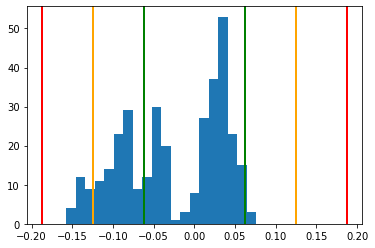

In [6]:
start_date = dt.date.today() - dt.timedelta(days=int(30))
end_date = dt.date.today()

btc = alpaca.get_crypto_bars("BTCUSD", TimeFrame.Hour, start_date, end_date).df
btc = btc[btc['exchange'] == 'CBSE'] # Keep data from only CBSE exchange
coin = alpaca.get_bars("COIN", TimeFrame.Hour, start_date, end_date).df
btc['BTC_minutely_return'] = btc['close'].pct_change().dropna()
coin['COIN_minutely_return'] = coin['close'].pct_change().dropna()
btc['BTC_return'] = btc['BTC_minutely_return'].add(1).cumprod().sub(1) # cumulative return: (1 + return_1) * (1 + return_2) * …
coin['COIN_return'] = coin['COIN_minutely_return'].add(1).cumprod().sub(1)

data = pd.DataFrame()
data["BTC_return"] = btc['BTC_return']
data["COIN_return"] = coin["COIN_return"]
data["spread"] = data["BTC_return"] - data["COIN_return"]
data["spread_std"] = data["spread"].std()
data["spread_upper_std"] = 1 * data["spread_std"]
data["spread_lower_std"] = -1 * data["spread_std"]

data.dropna(inplace=True)


In [7]:

fig1 = px.line(btc, y='BTC_return', color_discrete_sequence=['red'])
fig2 = px.line(coin, y='COIN_return', color_discrete_sequence=['blue'])
fig3 = go.Figure(data=fig1.data + fig2.data)
fig3.show()


In [9]:
fig1 = px.line(data, y='spread',  color_discrete_sequence=['green'], render_mode='svg')
fig1.update_xaxes(
    rangebreaks=[ # hide weekends
        { 'pattern': 'day of week', 'bounds': [6, 1]},
        { 'pattern': 'hour', 'bounds':[23,11]}
    ])

In [11]:

fig2 = px.line(data * 1, y=['spread_upper_std', 'spread_lower_std'], color_discrete_sequence=['cyan'], render_mode='svg')
fig3 = px.line(data * 2, y=['spread_upper_std', 'spread_lower_std'], color_discrete_sequence=['gray'], render_mode='svg')
fig4 = px.line(data * 3, y=['spread_upper_std', 'spread_lower_std'], color_discrete_sequence=['red'], render_mode='svg')

fig5 = go.Figure(data=fig1.data + fig2.data + fig3.data + fig4.data)
fig5.update_xaxes(
    rangebreaks=[
        { 'pattern': 'day of week', 'bounds': [6, 1]},
        { 'pattern': 'hour', 'bounds':[23,11]}
    ])

# Other

In [ ]:
'''
 	Date 	    Name 	Close 	Open 	Return
0 	2016-01-04 	IBM 	135.95 	135.60 	0.002581
1 	2016-01-05 	IBM 	135.85 	136.76 	-0.006654
2 	2016-01-06 	IBM 	135.17 	134.38 	0.005879
3 	2016-01-07 	IBM 	132.86 	133.70 	-0.006283
4 	2016-01-08 	IBM 	131.63 	133.18 	-0.011638
'''

fig = px.strip(
    df, 
    x="Name", 
    y="Return", 
    category_orders={"Name": sorted(df.Name.unique())},
    color="Name"
)
fig.update_layout(yaxis_tickformat=".0%")
plot(fig) # Replace this line by fig.show() to use in a notebook

# Macro events

In [ ]:
econ_events = pd.read_excel('database_us_econom_indicators.xlsx',  parse_dates={'GMT Datetime': ['GMT Date', 'GMT Time']})
econ_events = econ_events[econ_events.Future == 'No']

### Number of macro events in database

In [ ]:
fig = px.histogram(econ_events, x="Short Name", title="Number of indicators values")
fig.update_layout(title_x=0.5) # location of legend

### How macro is reported after end of quarter

In [ ]:
data = econ_events[econ_events['Last Observation Date'].dt.strftime('%Y-%m') == '2022-06'].sort_values(by=['GMT Datetime'])
data['GMT Datetime'] = data['GMT Datetime'].dt.date
fig = px.bar(data, x="GMT Datetime", color="Indicator Type", hover_data=['Short Name'])
fig.update_xaxes(rangebreaks=[
        { 'pattern': 'day of week', 'bounds': [6, 1]} # remove weekends
        # { 'pattern': 'hour', 'bounds':[23,11]} # remove night hours
    ]
)
# fig.update_layout(xaxis_tickformat='%d-%b')
#fig.update_xaxes(dtick="M1",tickformat="%b\n%Y")
fig.show()

### Histogram of all events

In [ ]:
# If set plotly to default, this will not work
# pd.options.plotting.backend = "plotly" # Set default charting for pandas to plotly
econ_events['Actual'].hist(by=econ_events['Short Name'],figsize = (30,30))

with plotly

In [ ]:
fig = px.histogram(econ_events, x="Actual", facet_row_spacing=0.03, nbins=20,
                    facet_col_spacing=0.03, facet_col="Short Name", facet_col_wrap=4)
fig.update_layout(autosize=False,width=1400,height=2000,)
fig.update_xaxes(matches=None,showticklabels=True)
fig.update_yaxes(matches=None,showticklabels=True)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1])) # adjusting headers

# ETFDB

In [33]:
needed_cols = ['Universe','Character', 'Compare','Ticker Symbol', 'Fund Name', 'Refinitiv_Active', 'ISIN',	'Instrument', 
'Launch Date', 'Fund Type', 'Industry', 'Geographic Focus', 'Type', 'Long-Short', 'Leverage', 'Company Market Cap']
US_ETF_ALL=pd.read_excel('D:\\Data\\Other_data\\ETFDB.xlsx',
                        sheet_name='US_ETFs',
                        skiprows=list(range(0,1)),header=1,
                        index_col='Ticker Symbol',
                        usecols=needed_cols) # read hist index components
US_ETF_ALL=US_ETF_ALL[US_ETF_ALL.Universe=="US"] # There are also ETFs traded on XMUN

In [34]:
US_ETF_ALL['Launch Date'] = pd.to_datetime(US_ETF_ALL['Launch Date'], format='%Y-%m-%d')
US_ETF_ALL['Refinitiv_Active'] = pd.to_datetime(US_ETF_ALL['Refinitiv_Active'], format='%d.%m.%Y')
active_date = US_ETF_ALL.Refinitiv_Active.max()
US_ETF_ALL=US_ETF_ALL[US_ETF_ALL.Refinitiv_Active==active_date] # focus on currently active ETFs

In [35]:
US_ETF_ALL

Universe        Character Compare  \
Ticker Symbol                                     
SPY                 US              NaN     SPY   
IVV                 US              NaN     SPY   
VOO                 US  Non_transparent     NaN   
VTI                 US  Non_transparent     NaN   
QQQ                 US              NaN     QQQ   
...                ...              ...     ...   
BRLN                US              NaN     NaN   
DSMC                US              NaN     NaN   
SRHQ                US              NaN     NaN   
NSPL                US              NaN     NaN   
FLRU                US              NaN     NaN   

                                                Fund Name Refinitiv_Active  \
Ticker Symbol                                                                
SPY                                SPDR S&P 500 ETF Trust       2022-10-12   
IVV                              iShares Core S&P 500 ETF       2022-10-12   
VOO                           Vanguard 500 Index Fund;ETF       2022-10-12   
VTI            Vanguard Total Stock Market Index Fund;ETF       2022-10-12   
QQQ                            Invesco QQQ Trust Series 1       2022-10-12   
...                                                   ...              ...   
BRLN                     BlackRock Floating Rate Loan ETF       2022-10-12   
DSMC                   Distillate Small/Mid Cash Flow ETF       2022-10-12   
SRHQ                                   SRH US Quality ETF       2022-10-12   
NSPL                          NightShares 500 1x/1.5x ETF       2022-10-12   
FLRU                             Franklin FTSE Russia ETF       2022-10-12   

                       ISIN Instrument Launch Date Fund Type  \
Ticker Symbol                                                  
SPY            US78462F1030      SPY.P  1993-01-22    Equity   
IVV            US4642872000      IVV.P  2000-05-15    Equity   
VOO            US9229083632      VOO.P  2010-09-07    Equity   
VTI            US9229087690      VTI.P  2001-05-24    Equity   
QQQ            US46090E1038     QQQ.OQ  1999-03-10    Equity   
...                     ...        ...         ...       ...   
BRLN           US0925284053     BRLN.Z  2022-10-04      Bond   
DSMC           US26922B6671     DSMC.P  2022-10-05    Equity   
SRHQ           US2103221030     SRHQ.P  2022-10-05    Equity   
NSPL           US90470L4288     NSPL.P  2022-10-06    Equity   
FLRU           US35473P7289     FLRU.P  2018-02-08    Equity   

                             Industry          Geographic Focus Type  \
Ticker Symbol                                                          
SPY                       Diversified  United States of America   No   
IVV                       Diversified  United States of America   No   
VOO                       Diversified  United States of America   No   
VTI                       Diversified  United States of America   No   
QQQ                       Diversified  United States of America   No   
...                               ...                       ...  ...   
BRLN           Corporate (Bank Loans)  United States of America  NaN   
DSMC                      Diversified  United States of America  NaN   
SRHQ                      Diversified  United States of America  NaN   
NSPL                      Diversified  United States of America  NaN   
FLRU                      Diversified                    Russia   No   

              Long-Short Leverage  Company Market Cap  
Ticker Symbol                                          
SPY                 Long       No       334641.925790  
IVV                 Long       No       278056.539588  
VOO                 Long       No       250729.545201  
VTI                 Long       No       249109.118379  
QQQ                 Long       No       148177.807848  
...                  ...      ...                 ...  
BRLN                 NaN      NaN            0.000000  
DSMC                 NaN      NaN           10.005588  
SRHQ 

In [36]:
fig = px.scatter(US_ETF_ALL, x="Launch Date", y="Company Market Cap", color="Fund Type",
                 size='Company Market Cap', hover_data=['Fund Name',US_ETF_ALL.index])
fig.show()

In [37]:
EQUITY_ETF_NOT_LEVERAGE = US_ETF_ALL[(US_ETF_ALL['Fund Type']=="Equity") & (US_ETF_ALL['Leverage']=="No") & (US_ETF_ALL['Type']!="1 Stock")] # There are also ETFs traded on XMUN
EQUITY_ETF_NOT_LEVERAGE

Universe        Character Compare  \
Ticker Symbol                                     
SPY                 US              NaN     SPY   
IVV                 US              NaN     SPY   
VOO                 US  Non_transparent     NaN   
VTI                 US  Non_transparent     NaN   
QQQ                 US              NaN     QQQ   
...                ...              ...     ...   
OAIE                US        AI-driven     NaN   
BIDS                US              NaN     NaN   
RESI                US              NaN     NaN   
SHOC                US              NaN     NaN   
FLRU                US              NaN     NaN   

                                                   Fund Name Refinitiv_Active  \
Ticker Symbol                                                                   
SPY                                   SPDR S&P 500 ETF Trust       2022-10-12   
IVV                                 iShares Core S&P 500 ETF       2022-10-12   
VOO                              Vanguard 500 Index Fund;ETF       2022-10-12   
VTI               Vanguard Total Stock Market Index Fund;ETF       2022-10-12   
QQQ                               Invesco QQQ Trust Series 1       2022-10-12   
...                                                      ...              ...   
OAIE            Optimize AI Smart Sentiment Event-Driven ETF       2022-10-12   
BIDS                    Amplify Digital & Online Trading ETF       2022-10-12   
RESI           Kelly Residential & Apartment Real Estate ETF       2022-10-12   
SHOC                             Strive US Semiconductor ETF       2022-10-12   
FLRU                                Franklin FTSE Russia ETF       2022-10-12   

                       ISIN Instrument Launch Date Fund Type  \
Ticker Symbol                                                  
SPY            US78462F1030      SPY.P  1993-01-22    Equity   
IVV            US4642872000      IVV.P  2000-05-15    Equity   
VOO            US9229083632      VOO.P  2010-09-07    Equity   
VTI            US9229087690      VTI.P  2001-05-24    Equity   
QQQ            US46090E1038     QQQ.OQ  1999-03-10    Equity   
...                     ...        ...         ...       ...   
OAIE           US81752T5772     OAIE.P  2022-06-15    Equity   
BIDS           US0321087712     BIDS.P  2021-09-21    Equity   
RESI           US48817R5081     RESI.P  2022-01-12    Equity   
SHOC           US02072L6728     SHOC.P  2022-10-06    Equity   
FLRU           US35473P7289     FLRU.P  2018-02-08    Equity   

                                      Industry          Geographic Focus  \
Ticker Symbol                                                              
SPY                                Diversified  United States of America   
IVV                                Diversified  United States of America   
VOO                                Diversified  United States of America   
VTI                                Diversified  United States of America   
QQQ                                Diversified  United States of America   
...                                        ...                       ...   
OAIE                               Diversified  United States of America   
BIDS           Financials (Financial Services)                    Global   
RESI                               Real Estate  United States of America   
SHOC               Technology (Semiconductors)  United States of America   
FLRU                               Diversified                    Russia   

                    Type Long-Short Leverage  Company Market Cap  
Ticker Symbol                                                     
SPY                   No       Long       No       334641.925790  
IVV                   No       Long       No       278056.539588  
VOO                   No       Long       No       250729.545201  
VTI                   No       Long       No       249109.118379  
QQQ                   No       Long       No       148177.807848  
...  

In [40]:
fig = px.scatter(EQUITY_ETF_NOT_LEVERAGE, x="Geographic Focus", y="Industry", color="Type",
                 # size=count(),
                 hover_data=['Fund Name',EQUITY_ETF_NOT_LEVERAGE.index])
fig.show()

KeyError: (nan, '', '', '', '')